In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pylab
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [105]:
pasta = "."
arquivo_out = "casos_incendio_cluster.csv"

def estacoes(mes):
    if mes in [12, 1, 2]:
        return 'Verão'
    elif mes in [3, 4, 5]:
        return 'Outono'
    elif mes in [6, 7, 8]:
        return 'Inverno'
    else:
        return 'Primavera'

dataframes = []

#os.listdir lista dos os arquivos e diretórios dentro da pasta
for item in os.listdir(pasta):
    if item.startswith("20"):
      caminho_arquivo = os.path.join(pasta, item)  # Construa o caminho completo
      df = pd.read_csv(caminho_arquivo)
      dataframes.append(df)
#combinar os dataframes em um só
arquivo = pd.concat(dataframes, ignore_index=True)
arquivo = arquivo.sort_values(by=['ano', 'mês'], ascending=[False, True])

#adicionar a coluna de estação com base no mês
arquivo['estacao'] = arquivo['mês'].apply(estacoes)

#remover as duplicatas
arquivo = arquivo.drop_duplicates()

#(subset=["estado", "municipio", "bioma", "ano", "mês", "dia"])

arquivo.to_csv(arquivo_out, index=False)
arquivo

,lat,lon,estado,municipio,bioma,ano,mês,dia,estacao
1722535,-17.52869,-57.66138,MATO GROSSO,CÁCERES,Pantanal,2023,1,2,Verão
1722536,-17.61373,-57.48255,MATO GROSSO,POCONÉ,Pantanal,2023,1,2,Verão
1722537,-17.61592,-57.47493,MATO GROSSO,POCONÉ,Pantanal,2023,1,2,Verão
1722538,-5.45368,-46.83593,MARANHÃO,AMARANTE DO MARANHÃO,Cerrado,2023,1,2,Verão
1722539,-8.42510,-46.00357,MARANHÃO,TASSO FRAGOSO,Cerrado,2023,1,2,Verão
...,...,...,...,...,...,...,...,...,...
175700,-2.34100,-46.17800,MARANHÃO,CENTRO DO GUILHERME,Amazônia,2014,12,17,Verão
175701,-2.43100,-46.90600,PARÁ,PARAGOMINAS,Amazônia,2014,12,16,Verão
175704,-1.90500,-54.01300,PARÁ,MONTE ALEGRE,Amazônia,2014,12,30,Verão
175711,-1.91500,-48.13200,PARÁ,ACARÁ,Amazônia,2014,12,20,Verão


In [106]:
print(arquivo.columns)

Index(['lat', 'lon', 'estado', 'municipio', 'bioma', 'ano', 'mês', 'dia',
       'estacao'],
      dtype='object')


In [107]:
#agregar o número de ocorrências de queimadas por estado e mês
arquivo.rename(columns={'ano': 'year', 'mês': 'month', 'dia': 'day'}, inplace=True)
arquivo['data'] = pd.to_datetime(arquivo[['year', 'month', 'day']])

queimadas_por_estado = (
    arquivo.groupby(['estado', arquivo['data'].dt.to_period('M')])
    .size()
    .reset_index(name='ocorrencias')
)

In [108]:
#tabela de características para a clusterização
#linhas são estados e colunas os meses
#valores são contagens de queimadas em cada estado por mês

tabela_cluster = queimadas_por_estado.pivot_table(
    index='estado', 
    columns='data', 
    values='ocorrencias', 
    fill_value=0
)

In [109]:
#normalização dos dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(tabela_cluster)

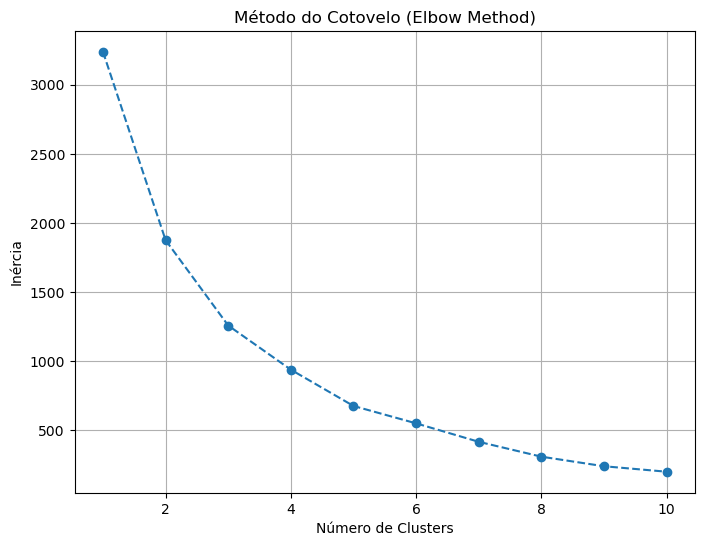

In [110]:
#cálculo da inércia para diferentes números de clusters (método do cotovelo)
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(8, 6))

#plotar o método do cotovelo
ax.plot(k_range, inertias, marker='o', linestyle='--')
ax.set_title('Método do Cotovelo (Elbow Method)')
ax.set_xlabel('Número de Clusters')
ax.set_ylabel('Inércia')
ax.grid(True)

plt.show()

fig.savefig('metodo_cotovelo.png', dpi=100, bbox_inches='tight', orientation='portrait')


In [111]:
#aplicar o KMeans para encontrar clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
tabela_cluster['cluster'] = clusters

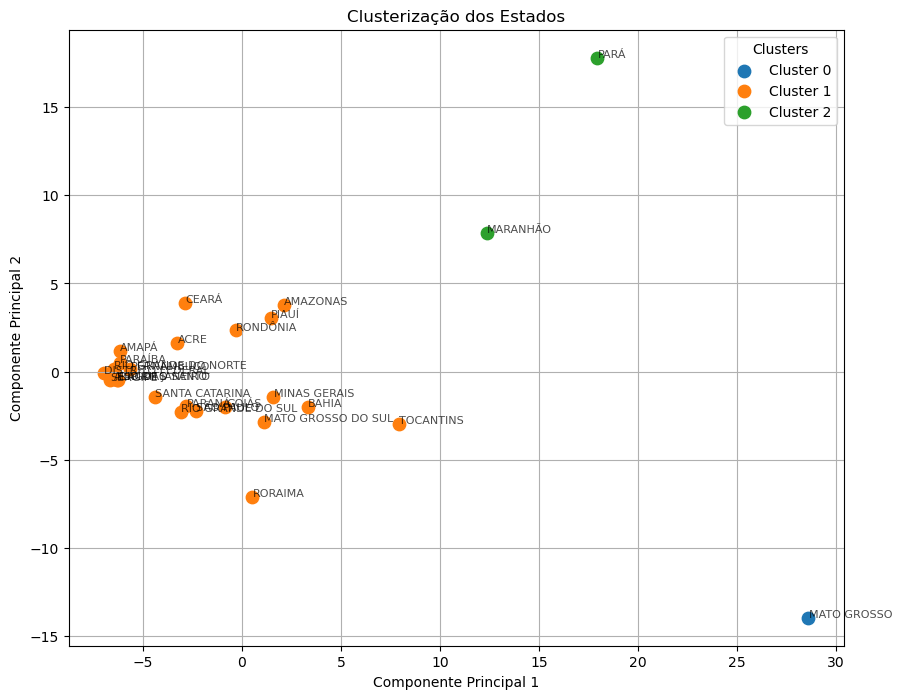

In [112]:
#redução da dimensionalidade para visualização (PCA)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

fig, ax = plt.subplots(figsize=(10, 8))

for cluster_id in set(clusters):
    cluster_points = reduced_data[clusters == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=80)

    
    cluster_states = tabela_cluster[tabela_cluster['cluster'] == cluster_id].index.tolist()
    for i, state in enumerate(cluster_states):
        if i < len(cluster_points):  #evitar erro caso faltem pontos
            x, y = cluster_points[i, 0], cluster_points[i, 1]
            ax.text(x + 0.02, y + 0.02, state, fontsize=8, alpha=0.7, ha='left')


ax.set_title('Clusterização dos Estados')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.legend(title='Clusters')
ax.grid(True)

plt.show()

fig.savefig('clusterizacao_estados.png', dpi=100, bbox_inches='tight', orientation='portrait')


In [113]:
resumo_cluster = tabela_cluster.drop(columns='cluster').groupby(tabela_cluster['cluster']).apply(
    lambda df: pd.Series({
        'media_total': df.mean().mean(),  
        'mediana_total': df.median().median(), 
        'desvio_padrao_total': df.stack().std(),  
        'minimo_total': df.min().min(),  
        'maximo_total': df.max().max()}))

print(resumo_cluster)


         media_total  mediana_total  desvio_padrao_total  minimo_total  \
cluster                                                                  
0        2342.525000        1183.00          3087.161441         134.0   
1         371.239583          63.75           858.336082           0.0   
2        2342.345833         950.75          2982.659709          13.0   

         maximo_total  
cluster                
0             20312.0  
1              8659.0  
2             15735.0  


In [114]:
#contar ocorrências de queimadas por estado e mês
queimadas_por_estado = (arquivo.groupby(['estado', arquivo['data'].dt.to_period('M')])
    .size()
    .reset_index(name='ocorrencias')
)

#criar a tabela de características para a clusterização
tabela_cluster = queimadas_por_estado.pivot_table(
    index='estado', 
    columns='data', 
    values='ocorrencias', 
    fill_value=0
)

In [115]:
#adicionar a coluna de sazonalidade (estação do ano)
tabela_cluster['estacao'] = tabela_cluster.index.to_series().apply(
    lambda estado: estacoes(arquivo.loc[arquivo['estado'] == estado, 'month'].mode()[0])
)

#calcular a intensidade como a soma das ocorrências mensais por estado
tabela_cluster['intensidade'] = tabela_cluster.select_dtypes(include='number').sum(axis=1)

#mapear estações para variáveis numéricas (Verão = 0, Outono = 1, Inverno = 2, Primavera = 3)
estacoes_map = {'Verão': 0, 'Outono': 1, 'Inverno': 2, 'Primavera': 3}
tabela_cluster['sazonalidade'] = tabela_cluster['estacao'].map(estacoes_map)

#selecionar as variáveis de intensidade e sazonalidade para clusterização
X = tabela_cluster[['intensidade', 'sazonalidade']]

In [116]:
#normalização dos dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [117]:
#aplicar o KMeans para encontrar clusters
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajuste o número de clusters conforme necessário
clusters = kmeans.fit_predict(scaled_data)

In [118]:
#adicionar os clusters ao dataframe
tabela_cluster['cluster'] = clusters

#reduzir a dimensionalidade para visualização (PCA)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

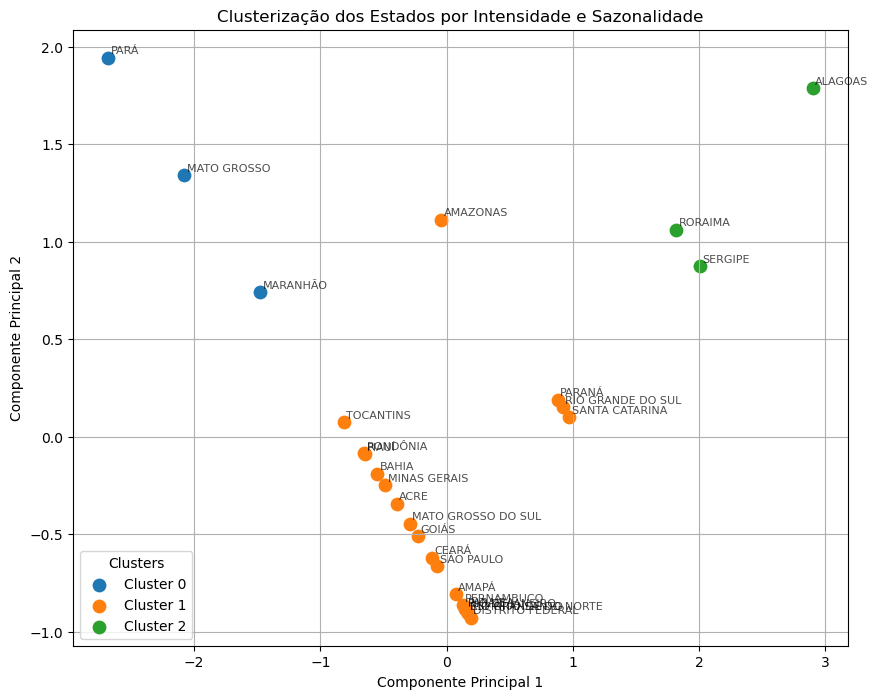

In [119]:
#plotar os clusters com rótulos ajustados para visualização

fig, ax = plt.subplots(figsize=(10, 8))

for cluster_id in set(clusters):
    cluster_points = reduced_data[clusters == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', s=80)

    cluster_states = tabela_cluster[tabela_cluster['cluster'] == cluster_id].index.tolist()
    for i, state in enumerate(cluster_states):
        if i < len(cluster_points):
            x, y = cluster_points[i, 0], cluster_points[i, 1]
            ax.text(x + 0.02, y + 0.02, state, fontsize=8, alpha=0.7, ha='left')

ax.set_title('Clusterização dos Estados por Intensidade e Sazonalidade')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.legend(title='Clusters')
ax.grid(True)

plt.show()

fig.savefig('clusterizacao_intens_sazon.png', dpi=100, bbox_inches='tight', orientation='portrait')

In [120]:
#sumário dos clusters
cluster_summary = tabela_cluster.groupby('cluster').agg({
    'intensidade': 'mean',   
    'sazonalidade': 'mean'   
}).reset_index()  
print(cluster_summary)

#contagem das estações por cluster
estacao_por_cluster = tabela_cluster.groupby('cluster')['estacao'].value_counts().unstack(fill_value=0)
print(estacao_por_cluster)


data  cluster    intensidade  sazonalidade
0           0  281088.666667      3.000000
1           1   49586.428571      2.809524
2           2    9285.000000      0.666667
estacao  Inverno  Outono  Primavera  Verão
cluster                                   
0              0       0          3      0
1              4       0         17      0
2              0       2          0      1
